# Skill Graph Construction and User Generation

This notebook:
1. Builds a skill co-occurrence graph from course data
2. Detects skill clusters using community detection
3. Generates realistic users based on discovered skill clusters

In [37]:
import pandas as pd
import numpy as np
import networkx as nx
from collections import defaultdict, Counter
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import json
import random
from datetime import datetime
import community as community_louvain  # python-louvain package

# Set random seed
np.random.seed(42)
random.seed(42)

print("Libraries imported successfully!")

Libraries imported successfully!


## 1. Load Course Data

In [38]:
# Load cleaned courses
courses_df = pd.read_csv('../data/processed/coursera_cleaned.csv')
print(f"Loaded {len(courses_df)} courses")
print(f"\nSample course skills:")
for i in range(3):
    print(f"  {courses_df.iloc[i]['Course Name'][:50]}...")
    print(f"  Skills: {courses_df.iloc[i]['skills_cleaned']}\n")

Loaded 3408 courses

Sample course skills:
  Write A Feature Length Screenplay For Film Or Tele...
  Skills: peering  film  dialogue  creative writing  writing

  Business Strategy: Business Model Canvas Analysis ...
  Skills: finance  business plan  persona (user experience)  business model canvas  planning  business  project  product development  presentation

  Silicon Thin Film Solar Cells...
  Skills: chemistry  physics  solar energy  film  lambda calculus  electrical engineering  electronics  energy



## 2. Build Skill Co-occurrence Graph

In [39]:
def parse_skills(skills_str):
    """Parse skills string into list of individual skills"""
    if pd.isna(skills_str) or skills_str.strip() == '':
        return []
    return [s.strip().lower() for s in skills_str.split('  ') if s.strip()]

# Extract all skills from all courses
all_skills = []
course_skills = []

for idx, row in courses_df.iterrows():
    skills = parse_skills(row['skills_cleaned'])
    if skills:
        course_skills.append(skills)
        all_skills.extend(skills)

print(f"Total courses with skills: {len(course_skills)}")
print(f"Total skill occurrences: {len(all_skills)}")
print(f"Unique skills: {len(set(all_skills))}")

Total courses with skills: 3408
Total skill occurrences: 19172
Unique skills: 655


In [40]:
# Count skill frequencies
skill_counts = Counter(all_skills)
print(f"\nTop 20 Most Common Skills:")
for skill, count in skill_counts.most_common(20):
    print(f"  {skill}: {count}")


Top 20 Most Common Skills:
  project: 395
  leadership and management: 363
  analysis: 344
  computer programming: 243
  machine learning: 239
  python programming: 226
  strategy: 215
  modeling: 205
  planning: 184
  communication: 171
  writing: 168
  data analysis: 153
  language: 152
  process: 152
  euler's totient function: 144
  finance: 143
  ordered pair: 142
  human learning: 136
  web: 136
  evaluation: 120


In [41]:
# Build co-occurrence matrix
# Count how many times each pair of skills appears together
co_occurrence = defaultdict(lambda: defaultdict(int))

for skills in course_skills:
    # For each pair of skills in this course
    for skill1, skill2 in combinations(set(skills), 2):
        co_occurrence[skill1][skill2] += 1
        co_occurrence[skill2][skill1] += 1

print(f"\nBuilt co-occurrence matrix for {len(co_occurrence)} skills")
print(f"Total skill pairs with co-occurrence: {sum(len(v) for v in co_occurrence.values()) // 2}")


Built co-occurrence matrix for 655 skills
Total skill pairs with co-occurrence: 22869


In [42]:
# Create NetworkX graph
G = nx.Graph()

# Add nodes (skills) with frequency as weight
for skill, count in skill_counts.items():
    G.add_node(skill, weight=count)

# Add edges (co-occurrences) with weight
# Only add edges with significant co-occurrence (threshold = 2)
min_cooccurrence = 2
for skill1, connections in co_occurrence.items():
    for skill2, weight in connections.items():
        if weight >= min_cooccurrence and skill1 < skill2:  # Avoid duplicates
            G.add_edge(skill1, skill2, weight=weight)

print(f"\nSkill Graph Statistics:")
print(f"  Nodes (skills): {G.number_of_nodes()}")
print(f"  Edges (co-occurrences): {G.number_of_edges()}")
print(f"  Connected components: {nx.number_connected_components(G)}")
print(f"  Average degree: {sum(dict(G.degree()).values()) / G.number_of_nodes():.2f}")


Skill Graph Statistics:
  Nodes (skills): 655
  Edges (co-occurrences): 8603
  Connected components: 1
  Average degree: 26.27


## 3. Detect Skill Clusters Using Louvain Community Detection

In [43]:
# Use Louvain community detection
# This finds densely connected groups of skills
communities = community_louvain.best_partition(G, weight='weight')

# Organize skills by cluster
clusters = defaultdict(list)
for skill, cluster_id in communities.items():
    clusters[cluster_id].append(skill)

print(f"\nDetected {len(clusters)} skill clusters")
print(f"\nCluster sizes:")
cluster_sizes = {cid: len(skills) for cid, skills in clusters.items()}
for cid, size in sorted(cluster_sizes.items(), key=lambda x: x[1], reverse=True)[:15]:
    print(f"  Cluster {cid}: {size} skills")


Detected 7 skill clusters

Cluster sizes:
  Cluster 0: 175 skills
  Cluster 1: 121 skills
  Cluster 2: 106 skills
  Cluster 5: 89 skills
  Cluster 4: 60 skills
  Cluster 6: 56 skills
  Cluster 3: 48 skills


In [44]:
# Display top clusters with their most common skills
print("\n" + "="*80)
print("TOP SKILL CLUSTERS")
print("="*80)

# Sort clusters by total skill frequency
cluster_importance = {}
for cid, skills in clusters.items():
    total_freq = sum(skill_counts[skill] for skill in skills)
    cluster_importance[cid] = total_freq

top_clusters = sorted(cluster_importance.items(), key=lambda x: x[1], reverse=True)[:15]

for rank, (cid, importance) in enumerate(top_clusters, 1):
    skills = clusters[cid]
    # Sort skills in cluster by frequency
    sorted_skills = sorted(skills, key=lambda s: skill_counts[s], reverse=True)
    
    print(f"\nCluster {rank} (ID: {cid}) - {len(skills)} skills, Importance: {importance}")
    print(f"  Top skills: {', '.join(sorted_skills[:15])}")
    if len(sorted_skills) > 15:
        print(f"  ... and {len(sorted_skills) - 15} more")


TOP SKILL CLUSTERS

Cluster 1 (ID: 0) - 175 skills, Importance: 5900
  Top skills: project, leadership and management, strategy, planning, communication, process, finance, evaluation, leadership, market (economics), marketing, thought, innovation, experience, accounting
  ... and 160 more

Cluster 2 (ID: 1) - 121 skills, Importance: 4185
  Top skills: analysis, machine learning, python programming, modeling, data analysis, euler's totient function, human learning, general statistics, algorithms, deep learning, analytics, tensorflow, regression, artificial neural networks, project mine
  ... and 106 more

Cluster 3 (ID: 2) - 106 skills, Importance: 2900
  Top skills: writing, language, history, english language, law, education, teaching, resource, presentation, music, psychology, art, speech, art history, grammar
  ... and 91 more

Cluster 4 (ID: 5) - 89 skills, Importance: 2488
  Top skills: computer programming, ordered pair, web, software, software engineering, html, web development

In [45]:
# Save clusters to file for reference
clusters_data = {}
for cid, skills in clusters.items():
    sorted_skills = sorted(skills, key=lambda s: skill_counts[s], reverse=True)
    clusters_data[f"cluster_{cid}"] = {
        'skills': sorted_skills,
        'size': len(skills),
        'total_frequency': sum(skill_counts[skill] for skill in skills),
        'top_5_skills': sorted_skills[:5]
    }

with open('../data/processed/skill_clusters.json', 'w') as f:
    json.dump(clusters_data, f, indent=2)
    
print("\nSaved skill clusters to ../data/processed/skill_clusters.json")


Saved skill clusters to ../data/processed/skill_clusters.json


## 4. Visualize Skill Graph (Sample)

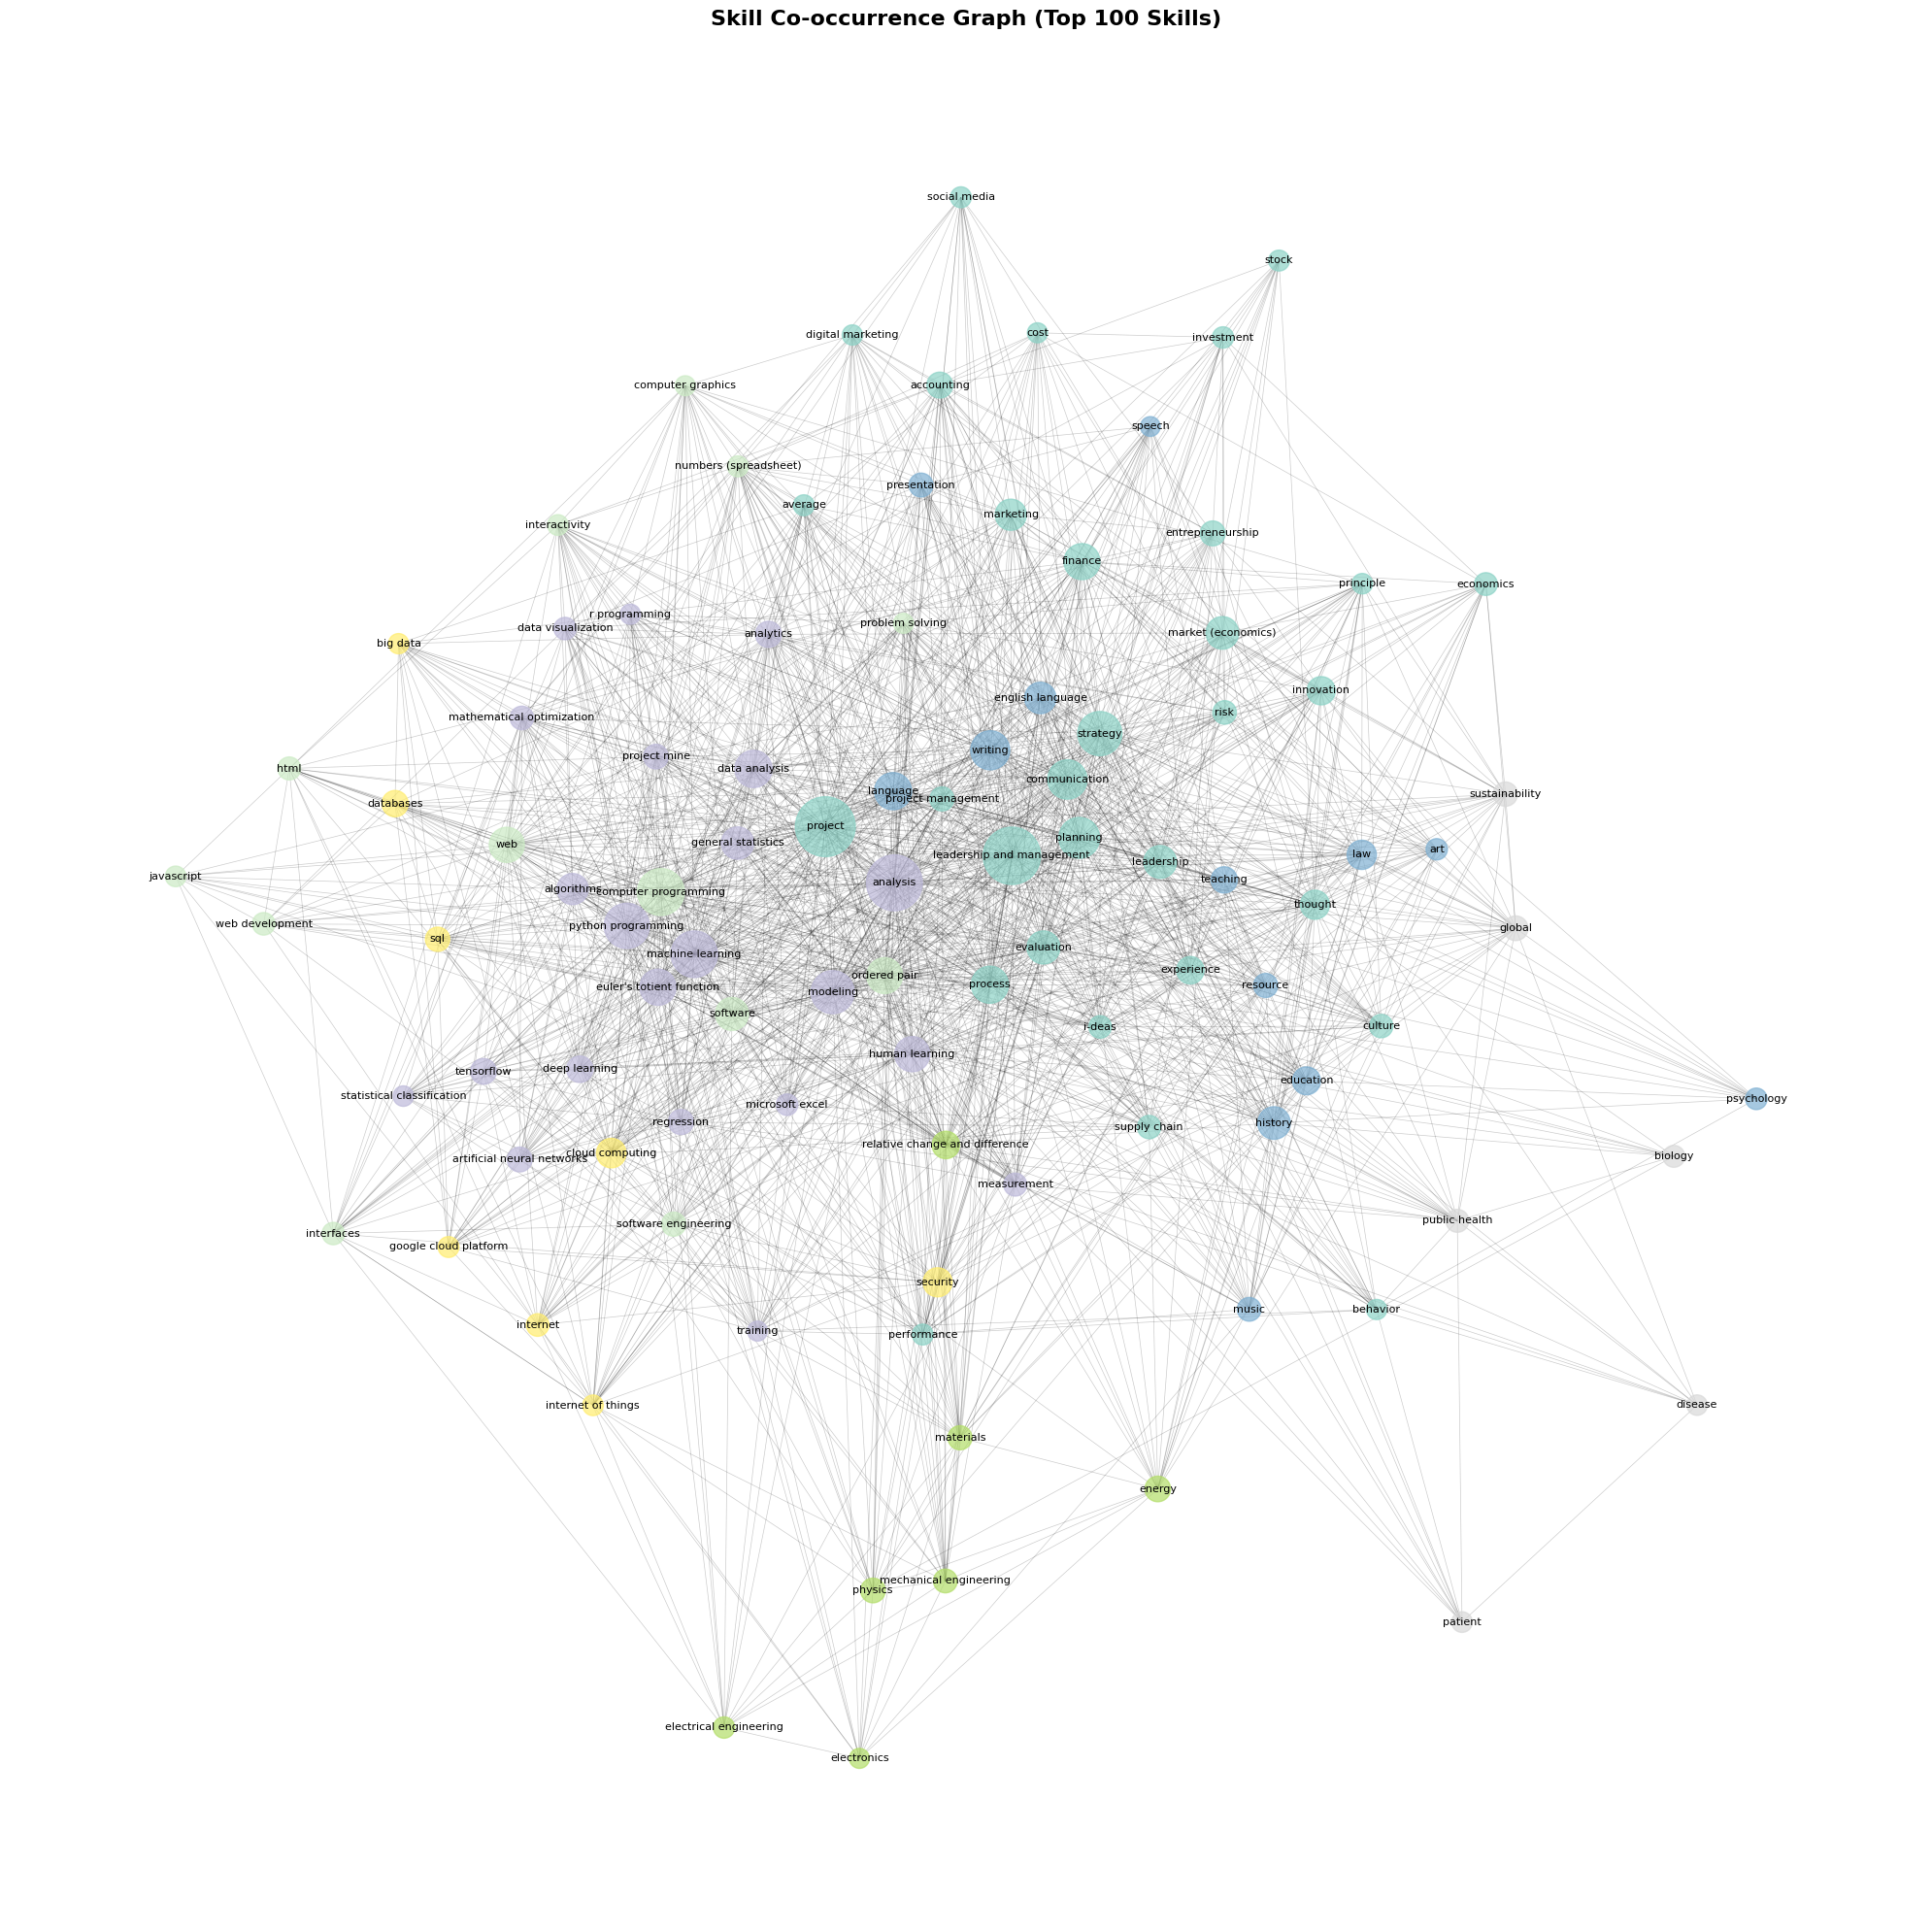

Saved skill graph visualization


In [46]:
# Visualize a subset of the graph (top skills only)
# Select top 100 most frequent skills
top_skills = [skill for skill, count in skill_counts.most_common(100)]
subgraph = G.subgraph(top_skills)

plt.figure(figsize=(20, 20))
pos = nx.spring_layout(subgraph, k=0.5, iterations=50)

# Color nodes by cluster
node_colors = [communities[node] for node in subgraph.nodes()]

# Draw
nx.draw_networkx_nodes(subgraph, pos, node_color=node_colors, 
                       node_size=[skill_counts[node]*5 for node in subgraph.nodes()],
                       cmap=plt.cm.Set3, alpha=0.7)
nx.draw_networkx_edges(subgraph, pos, alpha=0.2, width=0.5)
nx.draw_networkx_labels(subgraph, pos, font_size=8)

plt.title("Skill Co-occurrence Graph (Top 100 Skills)", fontsize=16, fontweight='bold')
plt.axis('off')
plt.tight_layout()
plt.savefig('../data/processed/skill_graph.png', dpi=150, bbox_inches='tight')
plt.show()

print("Saved skill graph visualization")

## 5. Generate Users Based on Skill Clusters

In [47]:
# Prepare cluster selection weights based on importance
cluster_weights = []
cluster_ids = []
for cid, importance in cluster_importance.items():
    cluster_ids.append(cid)
    cluster_weights.append(importance)

# Normalize weights
total_weight = sum(cluster_weights)
cluster_probs = [w / total_weight for w in cluster_weights]

print(f"Prepared {len(cluster_ids)} clusters for user generation")
print(f"Top 5 cluster probabilities: {[f'{p:.3f}' for p in sorted(cluster_probs, reverse=True)[:5]]}")

Prepared 7 clusters for user generation
Top 5 cluster probabilities: ['0.308', '0.218', '0.151', '0.130', '0.066']


In [48]:
def find_adjacent_clusters(cluster_id, G, communities, top_n=3):
    """Find clusters that are adjacent (connected) to the given cluster"""
    my_skills = clusters[cluster_id]
    
    # Find all skills connected to my cluster's skills
    adjacent_skills = set()
    for skill in my_skills:
        if skill in G:
            neighbors = G.neighbors(skill)
            adjacent_skills.update(neighbors)
    
    # Find which clusters these adjacent skills belong to
    adjacent_clusters = Counter()
    for skill in adjacent_skills:
        other_cluster = communities[skill]
        if other_cluster != cluster_id:
            adjacent_clusters[other_cluster] += 1
    
    # Return top N adjacent clusters
    return [cid for cid, _ in adjacent_clusters.most_common(top_n)]

def generate_user(user_id, clusters, cluster_ids, cluster_probs, G, communities, skill_counts):
    """Generate a single user with realistic skills based on clusters"""
    
    # Select 1-2 primary clusters
    num_primary = random.choices([1, 2], weights=[0.6, 0.4])[0]
    primary_clusters = np.random.choice(cluster_ids, size=num_primary, replace=False, p=cluster_probs)
    
    user_skills = {}
    
    # Select 2-4 skills from primary clusters
    for cluster_id in primary_clusters:
        cluster_skills = clusters[cluster_id]
        # Weight by skill frequency
        skill_weights = [skill_counts[s] for s in cluster_skills]
        skill_probs = np.array(skill_weights) / sum(skill_weights)
        
        num_skills = random.randint(2, 4) if num_primary == 1 else random.randint(1, 3)
        selected = np.random.choice(cluster_skills, size=min(num_skills, len(cluster_skills)), 
                                   replace=False, p=skill_probs)
        
        # Assign experience levels (3-5 for primary skills)
        for skill in selected:
            user_skills[skill] = random.randint(3, 5)
    
    # Find adjacent clusters and select 1-2 skills
    adjacent_clusters = []
    for cluster_id in primary_clusters:
        adjacent_clusters.extend(find_adjacent_clusters(cluster_id, G, communities))
    
    if adjacent_clusters:
        # Remove duplicates and primary clusters
        adjacent_clusters = list(set(adjacent_clusters) - set(primary_clusters))
        
        if adjacent_clusters:
            num_adjacent = random.randint(1, 2)
            selected_adjacent = random.sample(adjacent_clusters, min(num_adjacent, len(adjacent_clusters)))
            
            for cluster_id in selected_adjacent:
                cluster_skills = clusters[cluster_id]
                if cluster_skills:
                    skill = random.choice(cluster_skills)
                    # Assign lower experience for adjacent skills (2-4)
                    if skill not in user_skills:
                        user_skills[skill] = random.randint(2, 4)
    
    # Add 1-2 random skills from any cluster
    num_random = random.randint(1, 2)
    all_skills_list = list(skill_counts.keys())
    random_candidates = [s for s in all_skills_list if s not in user_skills]
    
    if random_candidates:
        random_skills = random.sample(random_candidates, min(num_random, len(random_candidates)))
        for skill in random_skills:
            # Random experience (1-3 for truly random skills)
            user_skills[skill] = random.randint(1, 3)
    
    return {
        'user_id': user_id,
        'skills': user_skills,
        'primary_clusters': primary_clusters.tolist(),
        'num_skills': len(user_skills)
    }

print("User generation function defined!")

User generation function defined!


In [49]:
# Generate 400 users
num_users = 400
users = []

for user_id in range(num_users):
    user = generate_user(user_id, clusters, cluster_ids, cluster_probs, G, communities, skill_counts)
    users.append(user)
    
    if (user_id + 1) % 100 == 0:
        print(f"Generated {user_id + 1}/{num_users} users")

print(f"\nGenerated {len(users)} users successfully!")

Generated 100/400 users
Generated 200/400 users
Generated 300/400 users
Generated 400/400 users

Generated 400 users successfully!


## 6. Analyze Generated Users

In [50]:
# Statistics
num_skills_per_user = [user['num_skills'] for user in users]
experience_levels = []
for user in users:
    experience_levels.extend(user['skills'].values())

print("=== User Generation Statistics ===")
print(f"\nTotal users: {len(users)}")
print(f"\nSkills per user:")
print(f"  Min: {min(num_skills_per_user)}")
print(f"  Max: {max(num_skills_per_user)}")
print(f"  Mean: {np.mean(num_skills_per_user):.2f}")
print(f"  Median: {np.median(num_skills_per_user):.0f}")

print(f"\nExperience level distribution:")
exp_counts = Counter(experience_levels)
for level in sorted(exp_counts.keys()):
    count = exp_counts[level]
    pct = count / len(experience_levels) * 100
    label = ['', 'Beginner', 'Elementary', 'Intermediate', 'Advanced', 'Expert'][level]
    print(f"  Level {level} ({label}): {count} ({pct:.1f}%)")

=== User Generation Statistics ===

Total users: 400

Skills per user:
  Min: 4
  Max: 10
  Mean: 6.48
  Median: 6

Experience level distribution:
  Level 1 (Beginner): 177 (6.8%)
  Level 2 (Elementary): 401 (15.5%)
  Level 3 (Intermediate): 870 (33.6%)
  Level 4 (Advanced): 640 (24.7%)
  Level 5 (Expert): 503 (19.4%)


In [51]:
# Most common skills among users
all_user_skills = []
for user in users:
    all_user_skills.extend(user['skills'].keys())

user_skill_counts = Counter(all_user_skills)

print("\n=== Top 30 Most Common Skills Among Users ===")
for skill, count in user_skill_counts.most_common(30):
    pct = count / len(users) * 100
    print(f"  {skill}: {count} users ({pct:.1f}%)")


=== Top 30 Most Common Skills Among Users ===
  leadership and management: 27 users (6.8%)
  computer programming: 21 users (5.2%)
  python programming: 20 users (5.0%)
  analysis: 20 users (5.0%)
  project: 19 users (4.8%)
  machine learning: 19 users (4.8%)
  modeling: 17 users (4.2%)
  language: 17 users (4.2%)
  strategy: 16 users (4.0%)
  databases: 15 users (3.8%)
  euler's totient function: 15 users (3.8%)
  web: 15 users (3.8%)
  data analysis: 14 users (3.5%)
  software: 12 users (3.0%)
  regression: 11 users (2.8%)
  cloud computing: 11 users (2.8%)
  market (economics): 11 users (2.8%)
  writing: 10 users (2.5%)
  deep learning: 10 users (2.5%)
  .properties: 10 users (2.5%)
  security: 10 users (2.5%)
  performance: 10 users (2.5%)
  studentized residual: 10 users (2.5%)
  ordered pair: 10 users (2.5%)
  general statistics: 10 users (2.5%)
  numbers (spreadsheet): 10 users (2.5%)
  law: 10 users (2.5%)
  jpeg: 9 users (2.2%)
  process: 9 users (2.2%)
  training and develop

In [52]:
# Sample users
print("\n" + "="*80)
print("SAMPLE USERS")
print("="*80)

for i in range(5):
    user = users[i]
    print(f"\nUser {user['user_id']}:")
    print(f"  Primary Clusters: {user['primary_clusters']}")
    print(f"  Total Skills: {user['num_skills']}")
    print(f"  Skills and Experience:")
    
    # Sort by experience level
    sorted_skills = sorted(user['skills'].items(), key=lambda x: x[1], reverse=True)
    for skill, exp in sorted_skills:
        exp_label = ['', 'Beginner', 'Elementary', 'Intermediate', 'Advanced', 'Expert'][exp]
        print(f"    - {skill}: {exp} ({exp_label})")


SAMPLE USERS

User 0:
  Primary Clusters: [2, 1]
  Total Skills: 5
  Skills and Experience:
    - writing: 5 (Expert)
    - consumer behaviour: 4 (Advanced)
    - regression: 3 (Intermediate)
    - natural language processing: 3 (Intermediate)
    - jpeg: 2 (Elementary)

User 1:
  Primary Clusters: [6]
  Total Skills: 5
  Skills and Experience:
    - software engineering: 4 (Advanced)
    - authentication: 3 (Intermediate)
    - digital signature: 3 (Intermediate)
    - korean language: 3 (Intermediate)
    - product management: 2 (Elementary)

User 2:
  Primary Clusters: [0, 6]
  Total Skills: 6
  Skills and Experience:
    - cloud computing: 4 (Advanced)
    - databases: 4 (Advanced)
    - sql: 4 (Advanced)
    - informatics: 3 (Intermediate)
    - keras: 3 (Intermediate)
    - deep learning: 2 (Elementary)

User 3:
  Primary Clusters: [0]
  Total Skills: 7
  Skills and Experience:
    - principle: 5 (Expert)
    - trading: 4 (Advanced)
    - process: 3 (Intermediate)
    - natural 

## 7. Save Generated Users

In [53]:
# Convert to DataFrame format
users_data = []
for user in users:
    # Create arrays for skills and experience
    # Convert to regular Python strings to avoid np.str_() in CSV
    skills_list = [str(skill) for skill in user['skills'].keys()]
    experience_list = [int(exp) for exp in user['skills'].values()]
    
    users_data.append({
        'user_id': user['user_id'],
        'skills': skills_list,
        'experience_levels': experience_list,
        'skills_text': '  '.join(skills_list),
        'num_skills': user['num_skills'],
        'primary_clusters': user['primary_clusters'],
        'avg_experience': float(np.mean(experience_list))
    })

users_df = pd.DataFrame(users_data)

# Save to CSV
output_path = '../data/processed/synth_users.csv'
users_df.to_csv(output_path, index=False)
print(f"Saved users to {output_path}")

# Save metadata
metadata = {
    'generation_date': datetime.now().isoformat(),
    'num_users': len(users),
    'num_clusters': len(clusters),
    'total_unique_skills': len(skill_counts),
    'skills_per_user': {
        'min': int(min(num_skills_per_user)),
        'max': int(max(num_skills_per_user)),
        'mean': float(np.mean(num_skills_per_user)),
        'median': float(np.median(num_skills_per_user))
    },
    'experience_distribution': {str(k): int(v) for k, v in sorted(exp_counts.items())},
    'top_20_user_skills': [{'skill': skill, 'count': count} 
                           for skill, count in user_skill_counts.most_common(20)]
}

metadata_path = '../data/processed/synth_users_metadata.json'
with open(metadata_path, 'w') as f:
    json.dump(metadata, f, indent=2)
print(f"Saved metadata to {metadata_path}")

print("\n=== Generation Complete ===")
print(f"Users: {len(users)}")
print(f"Average skills per user: {np.mean(num_skills_per_user):.2f}")
print(f"Skill clusters used: {len(clusters)}")

Saved users to ../data/processed/synth_users.csv
Saved metadata to ../data/processed/synth_users_metadata.json

=== Generation Complete ===
Users: 400
Average skills per user: 6.48
Skill clusters used: 7


In [54]:
# Display first few rows
print("\nFirst 5 users:")
print(users_df[['user_id', 'num_skills', 'avg_experience', 'primary_clusters']].head())


First 5 users:
   user_id  num_skills  avg_experience primary_clusters
0        0           5        3.400000           [2, 1]
1        1           5        3.000000              [6]
2        2           6        3.333333           [0, 6]
3        3           7        3.000000              [0]
4        4           5        2.600000              [5]
